In [5]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

FILE = 'dataset_31_credit-g.arff'

df = pd.DataFrame(arff.loadarff(FILE)[0])
df = df.dropna()
print(df.columns)
print(df.head(5))

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')
  checking_status  duration                     credit_history  \
0           b'<0'       6.0  b'critical/other existing credit'   
1     b'0<=X<200'      48.0                   b'existing paid'   
2  b'no checking'      12.0  b'critical/other existing credit'   
3           b'<0'      42.0                   b'existing paid'   
4           b'<0'      24.0              b'delayed previously'   

                  purpose  credit_amount       savings_status employment  \
0             b'radio/tv'         1169.0  b'no known savings'     b'>=7'   
1             b'radio/tv'         5951.0    

In [52]:
numeric_features = ['existing_credits', 'credit_amount', 'duration', 'installment_commitment']
nominal_features = ['housing', 'savings_status', 'employment']
target = 'class'

df_sub = pd.concat([df[numeric_features], df[nominal_features], df[target]], axis=1)

print(df_sub.isna().sum())
df_sub[numeric_features].describe()

existing_credits          0
credit_amount             0
duration                  0
installment_commitment    0
housing                   0
savings_status            0
employment                0
class                     0
dtype: int64


,existing_credits,credit_amount,duration,installment_commitment
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.407000,3271.258000,20.903000,2.973000
std,0.577654,2822.736876,12.058814,1.118715
min,1.000000,250.000000,4.000000,1.000000
25%,1.000000,1365.500000,12.000000,2.000000
50%,1.000000,2319.500000,18.000000,3.000000
75%,2.000000,3972.250000,24.000000,4.000000
max,4.000000,18424.000000,72.000000,4.000000


In [53]:
df_sub['housing'].value_counts()


housing
b'own'         713
b'rent'        179
b'for free'    108
Name: count, dtype: int64

In [54]:
df_sub['savings_status'].value_counts()

savings_status
b'<100'                603
b'no known savings'    183
b'100<=X<500'          103
b'500<=X<1000'          63
b'>=1000'               48
Name: count, dtype: int64

In [55]:
df_sub['employment'].value_counts()

employment
b'1<=X<4'        339
b'>=7'           253
b'4<=X<7'        174
b'<1'            172
b'unemployed'     62
Name: count, dtype: int64

In [56]:
df_sub[nominal_features].describe()

,housing,savings_status,employment
count,1000,1000,1000
unique,3,5,5
top,b'own',b'<100',b'1<=X<4'
freq,713,603,339


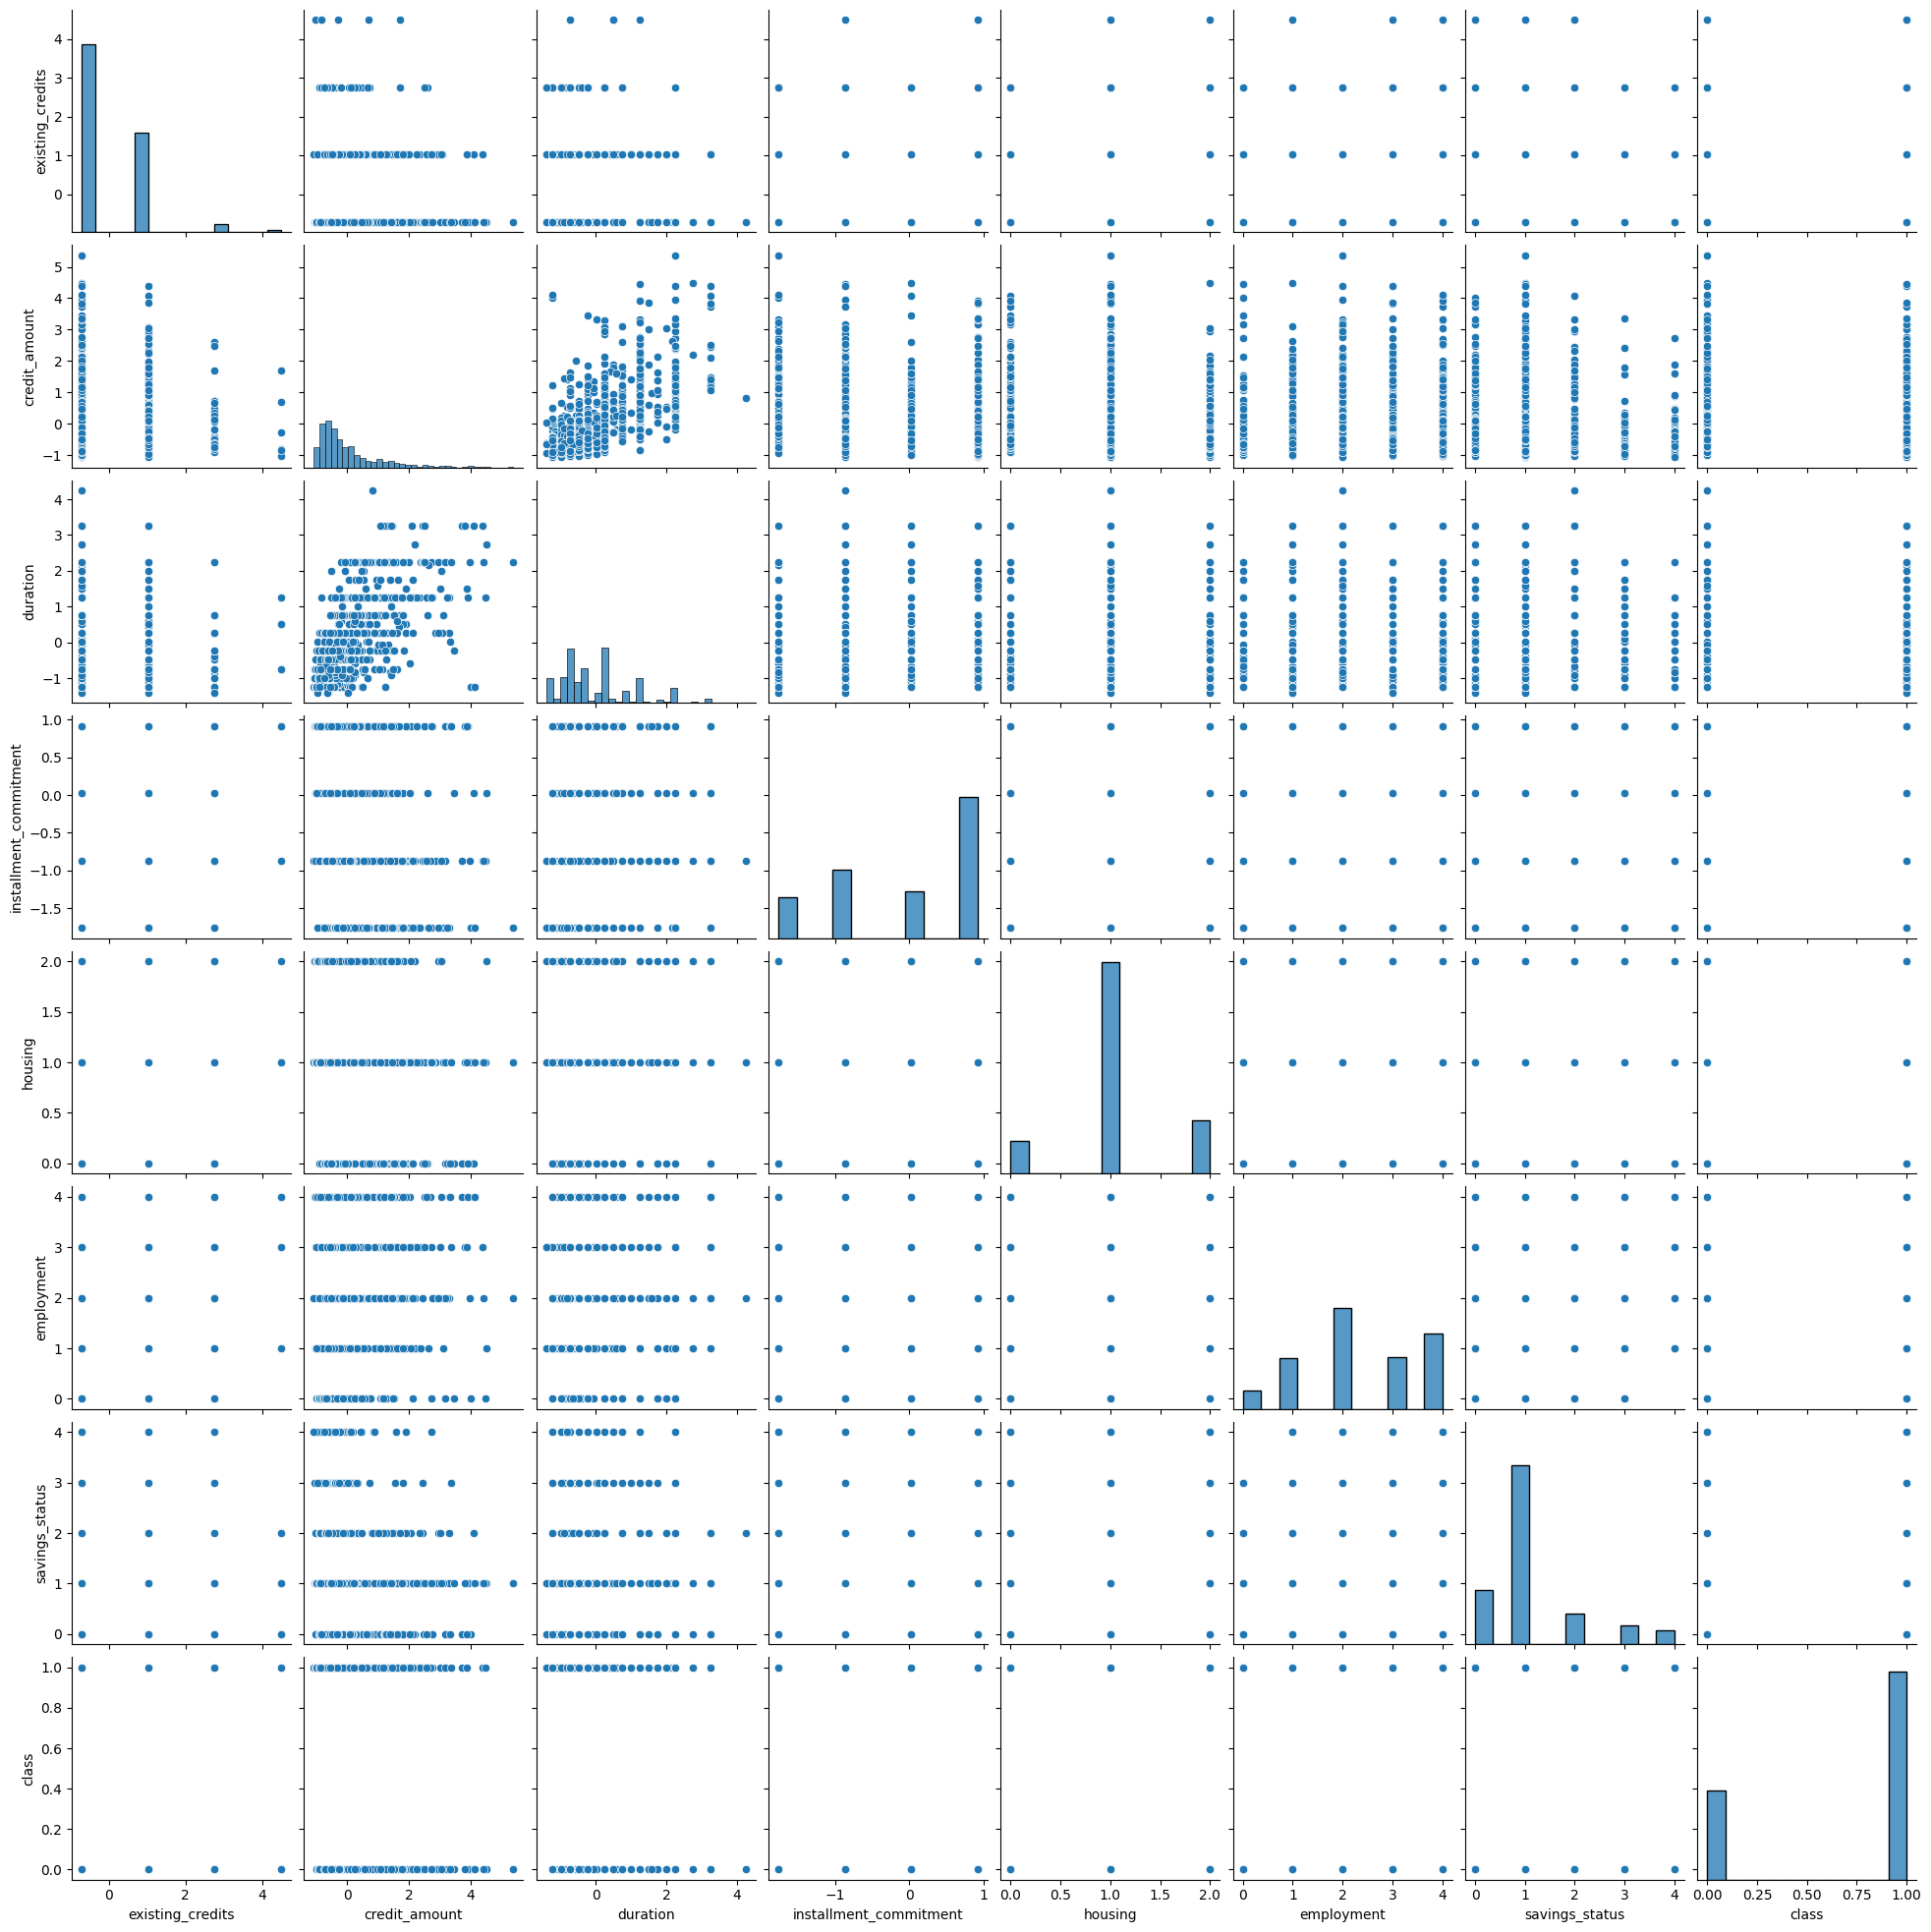

In [59]:
from sklearn.preprocessing import StandardScaler
df_processed = pd.DataFrame(StandardScaler().fit_transform(df_sub[numeric_features].to_numpy()), columns=numeric_features)
from sklearn.preprocessing import LabelEncoder
housing_encoded = pd.DataFrame(LabelEncoder().fit_transform(df_sub['housing'].to_numpy()), columns=['housing'])
df_processed = pd.concat([df_processed, housing_encoded], axis=1)

employment_vals = {b'unemployed': 0, b'<1': 1, b'1<=X<4': 2, b'4<=X<7': 3, b'>=7': 4}
savings_status_vals = {b'no known savings': 0, b'<100': 1, b'100<=X<500': 2, b'500<=X<1000': 3, b'>=1000': 4}

df_processed = pd.concat([df_processed, df_sub['employment'].apply(lambda x: employment_vals[x])], axis=1)
df_processed = pd.concat([df_processed, df_sub['savings_status'].apply(lambda x: savings_status_vals[x])], axis=1)

target_encoded = pd.DataFrame(LabelEncoder().fit_transform(df_sub[target].to_numpy()), columns=[target])
df_processed = pd.concat([df_processed, target_encoded], axis=1)

sns.pairplot(df_processed)

In [65]:
from sklearn.model_selection import train_test_split
df_train, df_test_valid = train_test_split(df_processed, test_size=0.2, random_state=0)
df_valid, df_test = train_test_split(df_test_valid, test_size=0.5, random_state=0)

y_train = df_train[target]
x_train = df_train.drop(target, axis=1)
y_valid = df_valid[target]
x_valid = df_valid.drop(target, axis=1)

from sklearn.neighbors import KNeighborsClassifier
best_score = -1000000
best_n = 0
for n in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    score = knn.score(x_valid, y_valid)
    if (score > best_score):
        best_score, best_n = score, n

print("Validation phase: the best mean accuracy score was %f with best nearest neighbors n=%d"%(best_score, best_n))



Validation phase: the best mean accuracy score was 0.720000 with best nearest neighbors n=15


Testing phase: the mean accuracy score is 0.750000 with nearest neighbors n=15
The final confusion matrix:


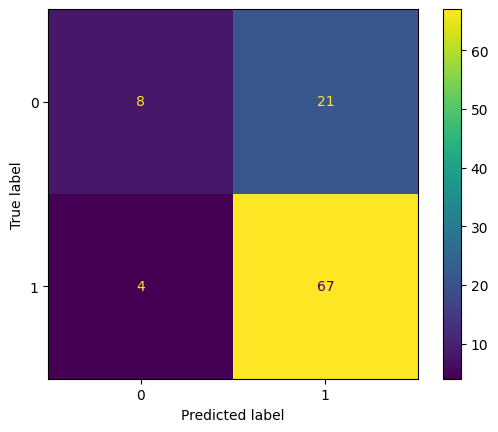

In [69]:
y_test = df_test[target]
x_test = df_test.drop(target, axis=1)

knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(x_train, y_train)
score = knn.score(x_test, y_test)

print("Testing phase: the mean accuracy score is %f with nearest neighbors n=%d"%(score, best_n))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = knn.predict(x_test)
print("The final confusion matrix:")
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(confusion_matrix=cm)
fig.plot()